In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from random import seed
from random import random
seed(1)

Defining the 30x20 rectangular grid and creating a prior mean and covariance. The covariance is built using a Matern covariance structure. 

In [2]:
#Grid dimensions
ne = 30 #east
nn = 20 #north
N = ne*nn #Total 

cell_size = 20
x_grid = np.arange(0,ne) * cell_size
y_grid = np.arange(0,nn) * cell_size
metric_x = np.array([[x for x in x_grid]for y in y_grid])
metric_y = np.array([[y for x in x_grid]for y in y_grid])

#Creating a distance matrix
df = pd.DataFrame()
df['east'] = np.reshape(metric_x, -1)
df['north'] = np.reshape(metric_y, -1)
H = distance_matrix(df.values, df.values)

#Generating the mean field
mean = np.arange(3,9,0.01)

# Creating the covariance matrix with a Matern covariance structure
var = np.arange(4,7,0.005) + random() #Generating a variance for each cell. 
phi = 0.02 #Kernel parameter 

R = (1+phi*H)*np.exp(-phi*H) 
    
for i in range(N):
    for j in range(N):
            H[i][j] = np.sqrt(var[i])*np.sqrt(var[j])*R[i][j]

covariance = np.copy(H)




Plotting the prior field. 

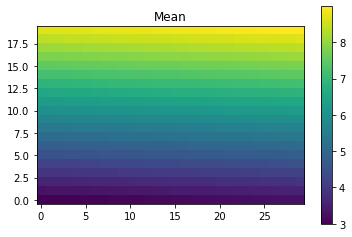

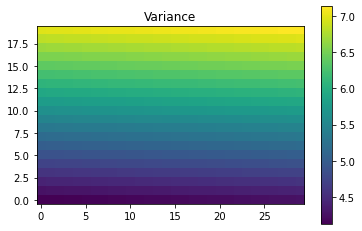

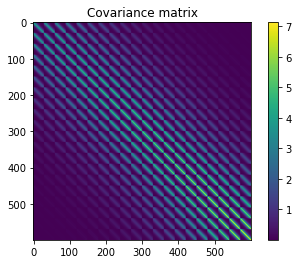

In [3]:
#Plotting
plt.figure()
plt.imshow(np.reshape(mean, (nn,ne)), origin = "lower")
plt.title("Mean")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.reshape(var, (nn,ne)), origin = "lower")
plt.title("Variance")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(H)
plt.title("Covariance matrix")
plt.colorbar()
plt.show()

### Kalman filter equations
$ R_t = A_t \Sigma_{t-1|t-1} A_t^T + \epsilon_t $

$Q_t = G_t R_t G_t^T + \Omega_t $ 

$K_t = R_t G_t^T Q_t^{-1} $

$\mu_{t|t}= A_t\mu_{t-1|t-1} + K_t(Y_t-G_tA_t\mu_{t-1|t-1}) $

$\Sigma_{t|t} = R_t - K_t Q_t K_t ^T$


In [4]:
def kalmanFilter(mean, covariance, A, G, observation, epsilon, tau):
    
    R = np.matmul(A,np.matmul(covariance, A)) + epsilon
    Q = np.matmul(G,np.matmul(R,G.transpose())) + tau
    K = np.matmul(R,np.matmul(G.transpose(), np.linalg.inv(Q)))

    updated_mean = np.matmul(A,mean) + np.matmul(K, (observation - np.matmul(G,np.matmul(A,mean))))
    updated_covariance = R - np.matmul(K,np.matmul(Q,K.transpose()))
    
    return(updated_mean, updated_covariance)

We do one update without a dynamic model. 

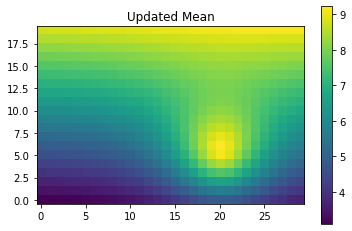

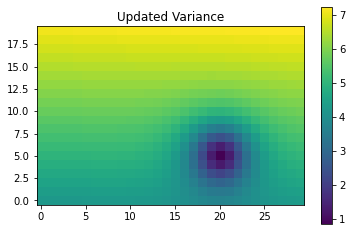

In [5]:
epsilon = 0.1 #Updating error
tau = 1 #Measurement error

m = 1 #Number of updating samples
sampling_index = 170
observation = 10 #Observation value

A = np.diag(np.ones(N)) #Without a temporal model we set A to a diagonal matrix

G = np.zeros((m,N))
G[0,sampling_index] = 1

[updated_mean, updated_covariance]=kalmanFilter(mean, covariance, A, G, observation, epsilon, tau)

var = np.diag(updated_covariance)

#Plotting
plt.figure()
plt.imshow(np.reshape(updated_mean, (nn,ne)), origin = "lower")
plt.title("Updated Mean")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.reshape(var, (nn,ne)), origin = "lower")
plt.title("Updated Variance")
plt.colorbar()
plt.show()

### Temporal model 
To add the temporal model we need to build our matrix A according to the SPDE model: 


$\frac{\partial X(t,s)}{\partial t} = \zeta X(t,s) - v_t^T \nabla X(t,s) + \nabla D \nabla X(t,s) + \epsilon(t,s)$

In [6]:
#Neighbor derivatives for Neumann boundary conditions
def neighborsDerivatives(i,ne,N):
    #(under,left,right,over)
    jumps = np.array((-ne, -1, 1, ne))
    
    #under
    if((i - ne) < 0):
        jumps[0]  = ne
    #over
    if((i + ne) > N-1):
        jumps[3] = -ne
    #left
    if((i % ne) == 0):
        jumps[1] = 1
    #right
    if((i % ne) == ne-1):
        jumps[2] = -1
  
    return(jumps+i)


def findingA(N,ne, ve,vn,D,zeta,dt,dx,dy):
    diag_const = zeta -2*D/(dx**2) -2*D/(dy**2)  # main
    diag_minus_1 = -(-ve/(2*dx))+ D/(dx**2)  #left
    diag_plus_1 = (-ve/(2*dx)) + D/(dx**2)   #right 
    diag_minus_N = -(-vn/(2*dy)) + D/(dy**2) #under 
    diag_plus_N = (-vn/(2*dy)) + D/(dy**2)   #over
    
    A = np.diag(diag_const)
  
    for i in range(N):
        neighbors = neighborsDerivatives(i,ne,N)
        for j in range(4):
            if(j==0):
                A[i,neighbors[j]] = A[i,neighbors[j]] + diag_minus_N[i]
            if(j==1):
                A[i,neighbors[j]] = A[i,neighbors[j]] + diag_minus_1[i]
            if(j==2):
                A[i,neighbors[j]] = A[i,neighbors[j]] + diag_plus_1[i]
            if(j==3):
                A[i,neighbors[j]] = A[i,neighbors[j]] + diag_plus_N[i]
  
    return (np.diag(np.ones(N)) + dt*A)

def forecasting(A,mean, covariance, epsilon):
    forecasted_mean = np.matmul(A, mean)
    forecasted_covariance = np.matmul(A,np.matmul(covariance, A.transpose())) + epsilon
    return(forecasted_mean, forecasted_covariance)



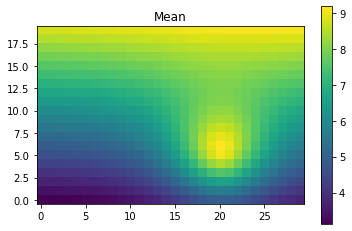

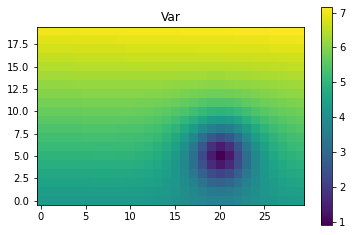

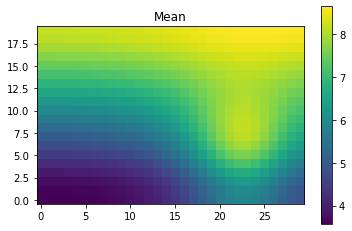

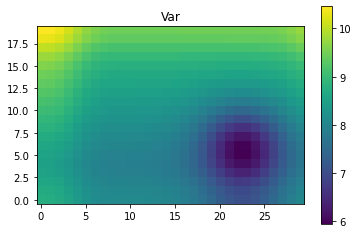

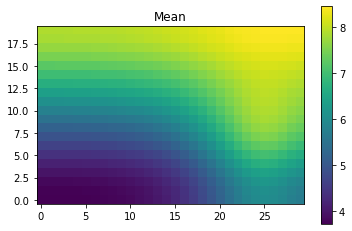

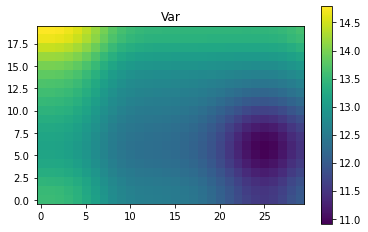

In [7]:
dx = 0.1
dy = 0.1
dt = 0.01

vn = np.repeat(0.1,N) #Advection parameters
ve = np.repeat(0.5,N)

D = 0.05 #Diffusion parameter
zeta = np.repeat(-0.0001,N) #Damping 

A = findingA(N,ne,ve,vn,D,zeta,dt,dx,dy) #Computing the propagator matrix

T_num = 150

mean = updated_mean
covariance = updated_covariance

for i in range(T_num):
    mean, covariance = forecasting(A, mean, covariance, epsilon)
    var = np.diag(covariance)
    
    if (i%50 == 0):
        plt.figure()
        plt.imshow(np.reshape(mean, (nn,ne)), origin = "lower")
        plt.title("Mean")
        plt.colorbar()
        plt.show()

        plt.figure()
        plt.imshow(np.reshape(var, (nn,ne)), origin = "lower")
        plt.title("Var")
        plt.colorbar()
        plt.show()



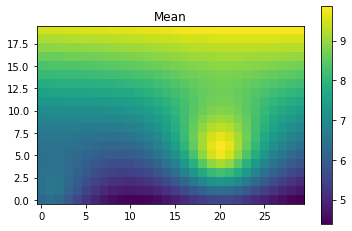

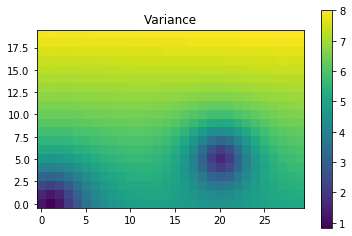

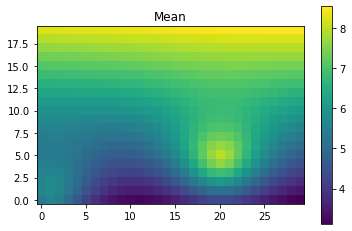

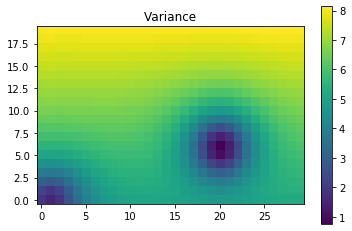

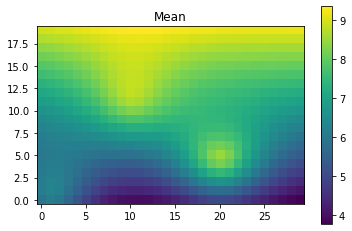

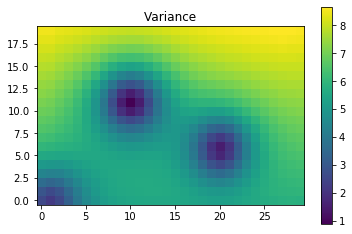

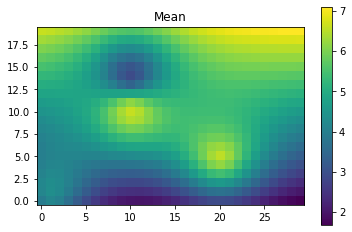

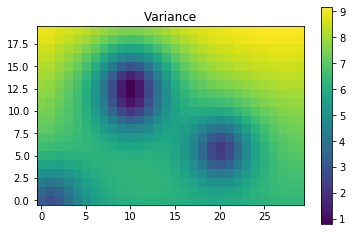

In [8]:
# Sequential run


dx = 1
dy = 1
dt = 0.01

vn = np.repeat(0.1,N) #Advection parameters
ve = np.repeat(0.5,N)

D = 0.1 #Diffusion parameter
zeta = np.repeat(-0.0001,N) #Damping 

A = findingA(N,ne,ve,vn,D,zeta,dt,dx,dy) #Computing the propagator matrix

epsilon = 1 #Updating error
tau = 1 #Measurement error

m = 1 # Samples per update
sampling_index = np.array((1,200,340,400))
observation = np.array((7,7,9,2))

mean = updated_mean
covariance = updated_covariance

for i in range(4):
    G = np.zeros((m,N))
    G[0,sampling_index[i]] = 1
    
    # Kalman filter with both the SPDE model and adding information from observations
    [mean, covariance]=kalmanFilter(mean, covariance, A, G, observation[i], epsilon, tau)
    var = np.diag(covariance)

    #Plotting
    plt.figure()
    plt.imshow(np.reshape(mean, (nn,ne)),origin = "lower")
    plt.title("Mean")
    plt.colorbar()
    plt.show()

    plt.figure()
    plt.imshow(np.reshape(var, (nn,ne)), origin = "lower")
    plt.title("Variance")
    plt.colorbar()
    plt.show()